In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [9]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [10]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [11]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [12]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [13]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


<img src="images/residual_skip_connections.png" width="800">

In [ ]:
# --- Causal Convolution ---
class CausalConv1d(nn.Module):
    """
    A 1D convolution that applies left-padding so that the convolution is causal.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        # We do not apply padding here, we'll handle it in forward
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=0, dilation=dilation)
    
    def forward(self, x):
        # x: (batch, channels, time)
        pad = (self.kernel_size - 1) * self.dilation
        # Pad on the left (only) so that no future information is used.
        x = F.pad(x, (pad, 0))
        return self.conv(x)

# --- WaveNet Residual Block ---
class WaveNetResidualBlock(nn.Module):
    """
    A single WaveNet block that performs:
      - Two causal dilated convolutions (for filter and gate)
      - Gated activation (tanh(filter) * sigmoid(gate))
      - 1x1 convolution for the residual output
      - 1x1 convolution for the skip connection
    """
    def __init__(self, residual_channels, skip_channels, kernel_size, dilation):
        super(WaveNetResidualBlock, self).__init__()
        self.conv_filter = CausalConv1d(residual_channels, residual_channels,
                                        kernel_size, dilation=dilation)
        self.conv_gate = CausalConv1d(residual_channels, residual_channels,
                                      kernel_size, dilation=dilation)
        self.conv_residual = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.conv_skip = nn.Conv1d(residual_channels, skip_channels, kernel_size=1)
    
    def forward(self, x):
        # x shape: (batch, residual_channels, time)
        filter_out = self.conv_filter(x)
        gate_out = self.conv_gate(x)
        # Apply gated activation unit
        gated_activation = torch.tanh(filter_out) * torch.sigmoid(gate_out)
        # Compute residual and skip outputs
        residual = self.conv_residual(gated_activation)
        skip = self.conv_skip(gated_activation)
        # Residual connection: add input x
        out = x + residual
        return out, skip

# --- WaveNet Model ---
class WaveNetModel(nn.Module):
    """
    WaveNet model for next-character prediction.
    
    Args:
      vocab_size: Number of characters in the vocabulary.
      n_embd: Dimensionality of the character embeddings (e.g., 24).
      dilations: List of dilation factors, e.g. [1, 2, 4, 8].
    """
    def __init__(self, vocab_size, n_embd, dilations):
        super(WaveNetModel, self).__init__()
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        residual_channels =  n_embd
        skip_channels =  n_embd

        # Embedding: converts character indices to vectors.
        self.embedding = nn.Embedding(vocab_size, n_embd)
        
        # Initial 1x1 convolution to map embedding dimension to residual channels.
        self.initial_conv = nn.Conv1d(n_embd, residual_channels, kernel_size=1)
        
        # Stack a sequence of WaveNet residual blocks
        self.res_blocks = nn.ModuleList([
            WaveNetResidualBlock(residual_channels, skip_channels, kernel_size=2, dilation=d)
            for d in dilations
        ])
        
        # Final processing: a couple of 1x1 convolutions with ReLU activations.
        self.final_layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(skip_channels, skip_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(skip_channels, vocab_size, kernel_size=1)
        )
    
    def forward(self, x):
        """
        Forward pass.
        Args:
          x: LongTensor of shape (batch, sequence_length) containing character indices.
        Returns:
          logits: Tensor of shape (batch, vocab_size) representing raw scores for the next character.
        """
        # Embed the input: (batch, seq_length) -> (batch, seq_length, n_embd)
        x = self.embedding(x)
        # Transpose to (batch, n_embd, seq_length) for 1D convs.
        x = x.transpose(1, 2)
        x = self.initial_conv(x)
        
        # Accumulate skip connections from all residual blocks.
        skip_sum = 0
        for res_block in self.res_blocks:
            x, skip = res_block(x)
            skip_sum = skip_sum + skip
        
        out = self.final_layers(skip_sum)
        # For next-character prediction, take the output at the last time step.
        logits = out[:, :, -1]  # shape: (batch, vocab_size)
        return logits

In [16]:
torch.manual_seed(42); # seed rng for reproducibility

In [19]:
n_embd = 24 # the dimensionality of the character embedding vectors
dilations = [1, 2, 4, 8]

# Create an instance of the model.
model = WaveNetModel(vocab_size, n_embd, dilations)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

max_steps = 200000
batch_size = 32
lossi = []
for step in range(max_steps):
    # Sample a random subset of the data
    ix = torch.randint(0, Xtr.size(0), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
  
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # track stats
    if step % 1000 == 0: # print every once in a while
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  


      0/ 200000: 4.6207
   1000/ 200000: 2.5025
   2000/ 200000: 2.2735
   3000/ 200000: 2.3337
   4000/ 200000: 2.2508
   5000/ 200000: 2.2727
   6000/ 200000: 1.8421
   7000/ 200000: 1.6884
   8000/ 200000: 2.1423
   9000/ 200000: 1.9282
  10000/ 200000: 2.0336
  11000/ 200000: 1.9139
  12000/ 200000: 2.1367
  13000/ 200000: 2.3079
  14000/ 200000: 1.7968
  15000/ 200000: 1.9649
  16000/ 200000: 2.3789
  17000/ 200000: 1.9502
  18000/ 200000: 2.0130
  19000/ 200000: 1.8557
  20000/ 200000: 2.2340
  21000/ 200000: 2.0547
  22000/ 200000: 2.1084
  23000/ 200000: 2.0256
  24000/ 200000: 2.3446
  25000/ 200000: 2.5261
  26000/ 200000: 2.1492
  27000/ 200000: 2.1127
  28000/ 200000: 1.7812
  29000/ 200000: 1.7995
  30000/ 200000: 2.3064
  31000/ 200000: 2.2722
  32000/ 200000: 1.8161
  33000/ 200000: 2.1238
  34000/ 200000: 1.9021
  35000/ 200000: 2.3482
  36000/ 200000: 2.4938
  37000/ 200000: 2.2492
  38000/ 200000: 1.8534
  39000/ 200000: 2.2530
  40000/ 200000: 2.0314
  41000/ 200000:

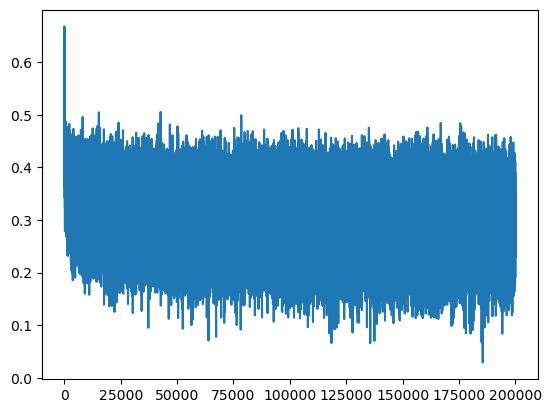

In [20]:
plt.plot(lossi)

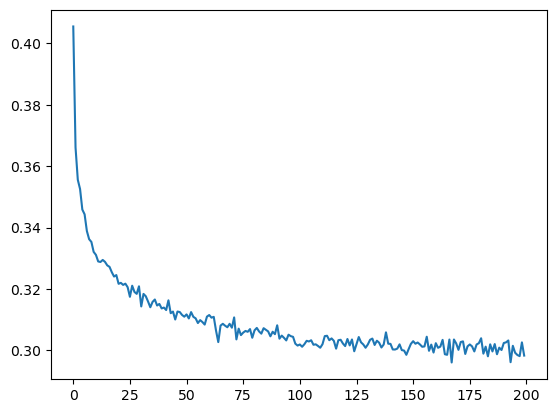

In [21]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.007701873779297
val 2.0868515968322754


With ~ 16k parameters  train 2.007701873779297 val 2.0868515968322754
In comparison previously we had train 1.7686203718185425 val 1.988585352897644 with 76k parameters

In [23]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context])) # (1,block_size) -> (1,vocab_size)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

aysasd.
kham.
mahni.
myrah.
deshawn.
elisona.
gansel.
bovanna.
makellio.
nolo.
kale.
kicklyn.
marclee.
rinacie.
oresros.
leyah.
lanaya.
nyshel.
mazell.
kaloh.


In [ ]:
  x = F.pad(x, (pad, 0))